In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydotplus
import seaborn as sns
import sklearn
import sys

from copy import deepcopy
from graphviz import Source
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import warnings


# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

RESULTS_PATH = os.path.join('./results')


# Getting the data & setup


In [46]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
# we probably wont use this until we know how to neural network
audio_df = pd.read_csv(DATA_PATH + 'audio_data.csv')
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')


In [47]:
song_dropped_df = song_dropped_df.drop(
    columns=['artist_name', 'track_name'])
song_filled_df = song_filled_df.drop(columns=['artist_name', 'track_name'])


In [48]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i += 1

modes = dict({song_filled_df['mode'].unique()[0]: 0,
             song_filled_df['mode'].unique()[1]: 1})

song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])


In [49]:
# getting a list of all genre names
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

# getting a list of all features in each data frame
audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')


In [50]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']


creating the initial splits


In [51]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)


Separating data from labels


In [52]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))


1000
40560
50000


Some methods do not work with the string labels, so we mapped the genre titles for each data set to unique integers


In [53]:
y_audio_nums = y_audio.copy()
y_audio_nums.replace(audio_genres, [x for x in range(10)], inplace=True)

y_dropped_nums = y_dropped.copy()
y_dropped_nums.replace(dropped_genres, [x for x in range(10)], inplace=True)

y_filled_nums = y_filled.copy()
y_filled_nums.replace(filled_genres, [x for x in range(10)], inplace=True)


In [54]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio_nums, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped_nums, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled_nums, test_size=0.30)

# Neural Network Modeling


## Prepararation


In [55]:
audio_results_metrics = pd.DataFrame()
dropped_results_metrics = pd.DataFrame()


In [56]:
# parameters:   pipe - model pipeline
#               params - dictionary of parameters specific to the model
#               X,y - X and y for the data set that should be used for cross validating
#               label - label of the data set
def run_grid_search(pipe, params, X, y, label, cv=None, n_jobs=-1):
    clf_GSCV = GridSearchCV(pipe, params, cv=cv)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

In [57]:
# defining the scaler we will be using
sc = StandardScaler()


## Training


In [57]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

nnclf = MLPClassifier()

nnclf_pipe = Pipeline(steps=[('sc', sc),
                             ('nnclf', nnclf)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

solvers = ['lbfgs']
activation_functions = ['logistic', 'tanh', 'relu']
hidden_layer_units = [[10, 10], [20, 20], [50, 50], [100, 100]]
alpha_units = [0.01, 0.1, 1.0, 5.0]


parameters = dict(nnclf__solver=solvers,
                  nnclf__activation=activation_functions,
                  nnclf__hidden_layer_sizes=hidden_layer_units,
                  nnclf__alpha=alpha_units)

nnclf_results_df = pd.DataFrame()
nnclf_results_df = nnclf_results_df.append(
    run_grid_search(nnclf_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
    run_grid_search(nnclf_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10))

nnclf_results_df.reset_index(inplace=True, drop=True)

nnclf_results_df


C:\Users\alexs\AppData\Local\Temp\ipykernel_12724\457809310.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nnclf_results_df = nnclf_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_12724\457809310.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(nnclf_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nnclf__activation,param_nnclf__alpha,param_nnclf__hidden_layer_sizes,param_nnclf__solver,params,split0_test_score,...,std_test_score,rank_test_score,label,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
0,0.151332,0.014052,0.001997,8.147115e-04,logistic,0.01,"[10, 10]",lbfgs,"{'nnclf__activation': 'logistic', 'nnclf__alph...",0.380240,...,0.025117,16,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.310264,0.005186,0.001665,4.717638e-04,logistic,0.01,"[20, 20]",lbfgs,"{'nnclf__activation': 'logistic', 'nnclf__alph...",0.362275,...,0.011001,38,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.516333,0.005735,0.002335,4.713147e-04,logistic,0.01,"[50, 50]",lbfgs,"{'nnclf__activation': 'logistic', 'nnclf__alph...",0.362275,...,0.011722,34,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.396338,0.074747,0.002999,8.991328e-07,logistic,0.01,"[100, 100]",lbfgs,"{'nnclf__activation': 'logistic', 'nnclf__alph...",0.347305,...,0.028612,37,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.135667,0.001880,0.001672,4.791260e-04,logistic,0.1,"[10, 10]",lbfgs,"{'nnclf__activation': 'logistic', 'nnclf__alph...",0.431138,...,0.019625,7,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,53.032924,0.782541,0.015600,4.898650e-04,relu,1.0,"[100, 100]",lbfgs,"{'nnclf__activation': 'relu', 'nnclf__alpha': ...",0.582101,...,0.007901,18,Dropped,0.589744,0.591716,0.596400,0.592209,0.571992,0.575937,0.576923
92,9.397292,0.125021,0.006197,6.063974e-04,relu,5.0,"[10, 10]",lbfgs,"{'nnclf__activation': 'relu', 'nnclf__alpha': ...",0.555227,...,0.011108,48,Dropped,0.557446,0.566815,0.584813,0.560404,0.549556,0.546351,0.544625
93,15.626965,0.117253,0.007193,5.983260e-04,relu,5.0,"[20, 20]",lbfgs,"{'nnclf__activation': 'relu', 'nnclf__alpha': ...",0.578402,...,0.006546,30,Dropped,0.577663,0.578402,0.595661,0.580621,0.580621,0.574458,0.569034
94,30.213790,0.417596,0.011001,9.993387e-04,relu,5.0,"[50, 50]",lbfgs,"{'nnclf__activation': 'relu', 'nnclf__alpha': ...",0.584813,...,0.009154,6,Dropped,0.593442,0.595907,0.605276,0.596400,0.573225,0.583826,0.580128


In [58]:
best_nnclf_audio = nnclf_results_df[(nnclf_results_df.rank_test_score == 1) &
                                    (nnclf_results_df.label == 'Audio')]

best_nnclf_dropped = nnclf_results_df[(nnclf_results_df.rank_test_score == 1) &
                                      (nnclf_results_df.label == 'Dropped')]


In [59]:
print('best audio parameters:\n',
      '\n--solver--\n', best_nnclf_audio.param_nnclf__solver.values,
      '\n--activation--\n', best_nnclf_audio.param_nnclf__activation.values,
      '\n--hidden_layer_sizes--\n', best_nnclf_audio.param_nnclf__hidden_layer_sizes.values,
      '\n--alpha--\n', best_nnclf_audio.param_nnclf__alpha.values)

print('\n\nbest dropped parameters:\n',
      '\n--solver--\n', best_nnclf_dropped.param_nnclf__solver.values,
      '\n--activation--\n', best_nnclf_dropped.param_nnclf__activation.values,
      '\n--hidden_layer_sizes--\n', best_nnclf_dropped.param_nnclf__hidden_layer_sizes.values,
      '\n--alpha--\n', best_nnclf_dropped.param_nnclf__alpha.values)


best audio parameters:
 
--solver--
 ['lbfgs'] 
--activation--
 ['tanh'] 
--hidden_layer_sizes--
 [list([50, 50])] 
--alpha--
 [5.0]


best dropped parameters:
 
--solver--
 ['lbfgs'] 
--activation--
 ['tanh'] 
--hidden_layer_sizes--
 [list([50, 50])] 
--alpha--
 [5.0]


In [58]:
# Added some more hyperparameters (learning rate and max iterations)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

nnclf = MLPClassifier()

nnclf_pipe = Pipeline(steps=[('sc', sc),
                             ('nnclf', nnclf)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

# Reduced the parameters we used before to just the optimal ones
# That way it doesn't take over a day to run
solvers = ['lbfgs']
activation_functions = ['tanh']
hidden_layer_units = [[50, 50]]
alpha_units = [5.0]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter = [100, 200, 300]

parameters = dict(nnclf__solver=solvers,
                  nnclf__activation=activation_functions,
                  nnclf__hidden_layer_sizes=hidden_layer_units,
                  nnclf__alpha=alpha_units,
                  nnclf__learning_rate=learning_rate,
                  nnclf__max_iter=max_iter)

nnclf_results_df = pd.DataFrame()
nnclf_results_df = nnclf_results_df.append(
    run_grid_search(nnclf_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
    run_grid_search(nnclf_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10))

nnclf_results_df.reset_index(inplace=True, drop=True)

nnclf_results_df

C:\Users\alexs\AppData\Local\Temp\ipykernel_2284\2149368831.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nnclf_results_df = nnclf_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_2284\2149368831.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(nnclf_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nnclf__activation,param_nnclf__alpha,param_nnclf__hidden_layer_sizes,param_nnclf__learning_rate,param_nnclf__max_iter,param_nnclf__solver,...,std_test_score,rank_test_score,label,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
0,0.344998,0.013369,0.002665,4.713752e-04,tanh,5.0,"[50, 50]",constant,100,lbfgs,...,0.012275,3,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.698670,0.016779,0.002332,4.730611e-04,tanh,5.0,"[50, 50]",constant,200,lbfgs,...,0.007400,4,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.044001,0.058806,0.002000,3.741138e-06,tanh,5.0,"[50, 50]",constant,300,lbfgs,...,0.006313,6,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.317000,0.006484,0.002332,4.753080e-04,tanh,5.0,"[50, 50]",invscaling,100,lbfgs,...,0.006719,9,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.686332,0.025039,0.002334,4.771024e-04,tanh,5.0,"[50, 50]",invscaling,200,lbfgs,...,0.003171,7,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.999667,0.058638,0.001996,2.081521e-06,tanh,5.0,"[50, 50]",invscaling,300,lbfgs,...,0.009611,2,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.346004,0.006481,0.002330,4.718203e-04,tanh,5.0,"[50, 50]",adaptive,100,lbfgs,...,0.003437,5,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.668006,0.018712,0.001996,1.755613e-06,tanh,5.0,"[50, 50]",adaptive,200,lbfgs,...,0.003911,1,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.003669,0.017746,0.001999,5.947204e-07,tanh,5.0,"[50, 50]",adaptive,300,lbfgs,...,0.007871,8,Audio,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,18.980425,0.732838,0.014494,1.287525e-03,tanh,5.0,"[50, 50]",constant,100,lbfgs,...,0.008330,9,Dropped,0.587032,0.590976,0.606509,0.591469,0.577663,0.591716,0.579389


In [59]:
best_nnclf_audio = nnclf_results_df[(nnclf_results_df.rank_test_score == 1) &
                                    (nnclf_results_df.label == 'Audio')]

best_nnclf_dropped = nnclf_results_df[(nnclf_results_df.rank_test_score == 1) &
                                      (nnclf_results_df.label == 'Dropped')]


In [60]:
print('best audio parameters:\n',
      '\n--solver--\n', best_nnclf_audio.param_nnclf__solver.values,
      '\n--activation--\n', best_nnclf_audio.param_nnclf__activation.values,
      '\n--hidden_layer_sizes--\n', best_nnclf_audio.param_nnclf__hidden_layer_sizes.values,
      '\n--alpha--\n', best_nnclf_audio.param_nnclf__alpha.values,
      '\n--learning_rate--\n', best_nnclf_audio.param_nnclf__learning_rate.values,
      '\n--max_iter--\n', best_nnclf_audio.param_nnclf__max_iter.values)

print('\n\nbest dropped parameters:\n',
      '\n--solver--\n', best_nnclf_dropped.param_nnclf__solver.values,
      '\n--activation--\n', best_nnclf_dropped.param_nnclf__activation.values,
      '\n--hidden_layer_sizes--\n', best_nnclf_dropped.param_nnclf__hidden_layer_sizes.values,
      '\n--alpha--\n', best_nnclf_dropped.param_nnclf__alpha.values,
      '\n--learning_rate--\n', best_nnclf_dropped.param_nnclf__learning_rate.values,
      '\n--max_iter--\n', best_nnclf_dropped.param_nnclf__max_iter.values)

best audio parameters:
 
--solver--
 ['lbfgs'] 
--activation--
 ['tanh'] 
--hidden_layer_sizes--
 [list([50, 50])] 
--alpha--
 [5.0] 
--learning_rate--
 ['adaptive'] 
--max_iter--
 [200]


best dropped parameters:
 
--solver--
 ['lbfgs'] 
--activation--
 ['tanh'] 
--hidden_layer_sizes--
 [list([50, 50])] 
--alpha--
 [5.0] 
--learning_rate--
 ['adaptive'] 
--max_iter--
 [300]


In [61]:
nnclf_pipe = Pipeline(steps=[('nnclf', nnclf)])

nnclf_audio = deepcopy(nnclf_pipe)
nnclf_audio.set_params(**best_nnclf_audio.params.values[0])
nnclf_audio.fit(X_audio_train, y_audio_train)
y_pred_nnclf_audio = nnclf_audio.predict(X_audio_test)

nnclf_dropped = deepcopy(nnclf_pipe)
nnclf_dropped.set_params(**best_nnclf_dropped.params.values[0])
nnclf_dropped.fit(X_dropped_train, y_dropped_train)
y_pred_nnclf_dropped = nnclf_dropped.predict(X_dropped_test)

In [62]:
nnclf_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_nnclf_audio, output_dict=True))
nnclf_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_nnclf_dropped, output_dict=True))

nnclf_result_metrics_audio['model_type'] = 'nnclf'
nnclf_result_metrics_dropped['model_type'] = 'nnclf'

audio_results_metrics = nnclf_result_metrics_audio
dropped_results_metrics = nnclf_result_metrics_dropped

print('Accuracy for audio: {:.3f}'.format(
    nnclf_result_metrics_audio['accuracy'].iloc[0]))
print('Accuracy for dropped: {:.3f}'.format(
    nnclf_result_metrics_dropped['accuracy'].iloc[0]))


Accuracy for audio: 0.460
Accuracy for dropped: 0.553


In [63]:
from tensorflow import keras as k
from keras.models import Sequential
from keras import callbacks

In [64]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="auto", patience = 30, 
                                        restore_best_weights = True)

In [65]:
def trainModel(model, epochs, optimizer, X_train, y_train, X_test, y_test):
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')
    return model.fit(X_train, y_train, validation_data=(X_test, y_test),
                     epochs=epochs, callbacks =[earlystopping])

In [66]:
def plotValidate(history):
    print("Validation Accuracy: " + max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show

In [67]:
X_audio_train.shape[1]

6

In [68]:
cnn_audio = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_audio_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])

print(cnn_audio.summary())
cnn_history_audio = trainModel(model=cnn_audio, epochs=300, optimizer='adam',
                               X_train=X_audio_train, y_train=y_audio_train,
                               X_test=X_audio_test, y_test=y_audio_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3584      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [69]:
test_loss_audio, test_acc_audio = cnn_audio.evaluate(X_audio_test, y_audio_test)
print("Test loss for audio data: ", test_loss_audio)
print("Best accuracy for audio data: ", test_acc_audio)


7/7 [==============================] - 0s 2ms/step - loss: 1.3550 - accuracy: 0.5050
Test loss for audio data:  1.3550256490707397
Best accuracy for audio data:  0.5049999952316284


In [70]:
cnn_dropped = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_dropped_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])

print(cnn_dropped.summary())
cnn_history_dropped = trainModel(model=cnn_dropped, epochs=300, optimizer='adam',
                               X_train=X_dropped_train, y_train=y_dropped_train,
                               X_test=X_dropped_test, y_test=y_dropped_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               7168      
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [71]:
test_loss_dropped, test_acc_dropped = cnn_dropped.evaluate(X_dropped_test, y_dropped_test)
print("Test loss for csv data: ", test_loss_dropped)
print("Best accuracy for csv data: ", test_acc_dropped)

381/381 [==============================] - 1s 2ms/step - loss: 1.0858 - accuracy: 0.5760
Test loss for csv data:  1.0858036279678345
Best accuracy for csv data:  0.5760190486907959


# Learning Curves

In [72]:
def plot_learning_curves(history, epochs):
    history_dict = history.history
    loss_values = history_dict['loss']
    acc_values = history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(epochs, loss_values, 'bo', label='Training Loss')
    ax1.plot(epochs, val_loss_values, 'orange', label='Validation Loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
    ax2.plot(epochs, val_acc_values, 'orange', label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

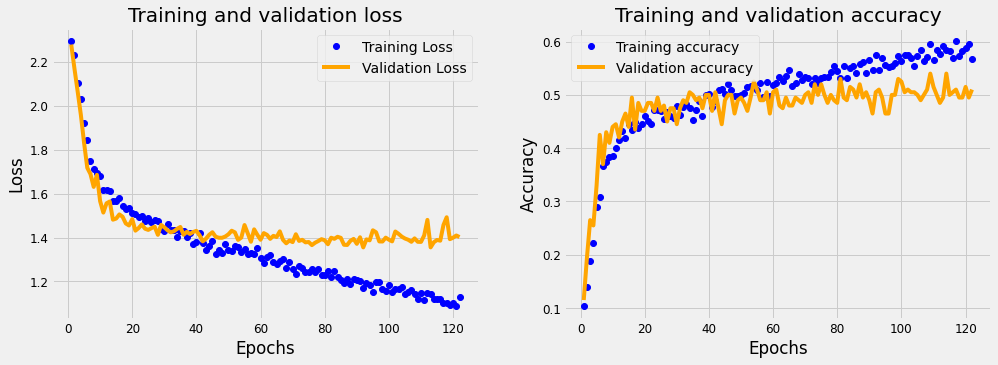

In [74]:
plot_learning_curves(cnn_history_audio, epochs=range(1, 123))

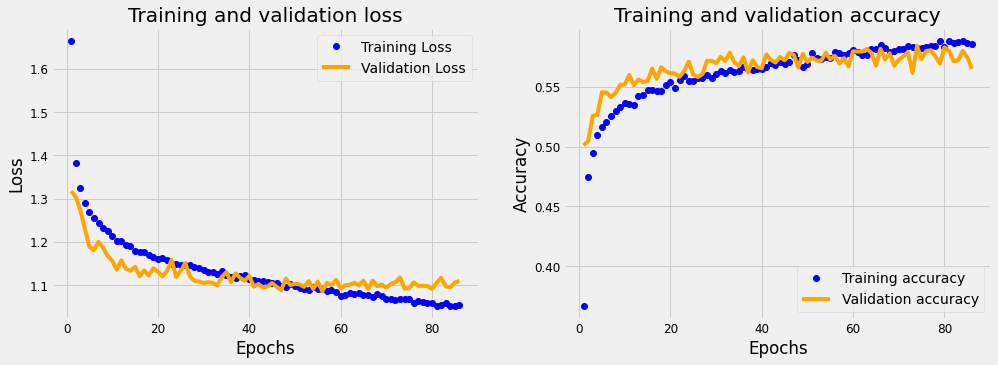

In [75]:
plot_learning_curves(cnn_history_dropped, epochs=range(1, 87))